In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.ticker as ticker
from scipy.integrate import simps
from scipy.optimize import curve_fit


from sklearn.linear_model import LinearRegression

In [39]:
BASE_PATH = '../tp5/out/flux/'

In [40]:
def get_linear_regresssion(df):
    x = np.array(df.index)
    y = np.array(df['sum'])
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m , c

In [4]:
def get_simulation_data(df):
    time_flux = df.groupby('time').agg({'ball_id':'count'}); 
    return {
        'discharge' : pd.DataFrame({'time': time_flux.index,'sum': time_flux.cumsum()['ball_id']})
    }

In [5]:
def plot_flux(figure,tiempo, discharge, line):
    plt.plot(tiempo, discharge,marker='x', label='Descarga')
    plt.plot(tiempo, line, label='Regresión lineal')
    plt.xlabel('Tiempo')
    plt.ylabel('Cantidad de pelotas')
    plt.grid(True)
    plt.legend()
    plt.savefig(figure)
    plt.clf()

In [6]:
def plot_map(name,plot_map, xlabel, ylabel, log_scale):
    x = [position for position in plot_map.keys()]
    y = [value[0] for value in plot_map.values()]
    errors = [value[1] for value in plot_map.values()]
        
    plt.errorbar(x, y, yerr=errors, fmt='o', color='black', ecolor='red', capsize=3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if log_scale:
        plt.yscale("log")
    plt.xticks(x)
    plt.grid(True)
    plt.savefig(name)
    plt.clf()

In [7]:
def get_charge(path):
    df = pd.read_csv(path)
    df = get_simulation_data(df)
    df = df['discharge']
    m, c = get_linear_regresssion(df)
    y = m * (df.index) + c
    S = np.sqrt(sum((df['sum'] - y) ** 2) / (len(df.time) - 2))
    time_mean = np.mean(df.index)
    SS = np.sqrt(sum((df.index - time_mean) ** 2))
    return m, (S/SS)
    

In [11]:
    # function for generating the discharge curve for the freq, 
    # receiving the csv path as parameter
    def plot_discharge_line_for_freq(freq, path):        
        df = pd.read_csv(path)
        df = get_simulation_data(df)
        df = df['discharge']
        m, c = get_linear_regresssion(df)
        y = m * (df.index) + c
        plot_flux(f'{freq}Discharge.png',df.index, df['sum'], y)

In [14]:
# generate the caudal vs frequency graph  
def plot_caudal_by_frequency():
    path = f"{BASE_PATH}/"
    frequencies = [5,10, 15, 20, 30, 50]
    result = {}
    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'*_i*.csv'
        files = Path(path).glob(regex)
        dfs = [get_charge(f) for f in files][0]
        result[freq] = dfs
    plot_map("fluxVsFreq.png", result, "Frecuencia", "Caudal", False)

plot_caudal_by_frequency()


<Figure size 640x480 with 0 Axes>

In [13]:
# generate all the discharge curves  
def plot_discharge_line():
    base = f"{BASE_PATH}/"
    frequencies = [5,10, 15, 20, 30, 50]
    for freq in frequencies: 
        regex = '*fq'+ str(freq)+'*_i*.csv'
        files = Path(base).glob(regex)
        path = [f for f in files][0]
        plot_discharge_line_for_freq(freq, path)
plot_discharge_line()
        

<Figure size 640x480 with 0 Axes>

In [22]:
def get_caudal_by_gap():
    path = f"{BASE_PATH}/"
    gaps = [4, 5, 6]
    caudales = []
    result = {}
    for gap in gaps: 
        regex = '*gap'+ str(gap)+'*_i*.csv'
        files = Path(path).glob(regex)
        caudal = [get_charge(f) for f in files][0]
        caudales.append(caudal[0])
        
    
    result["d"] = gaps
    result["q"] = caudales

    return result

In [23]:
def estimate_beverloo_constant(dictio):
    X = np.array(dictio["d"]).reshape(-1, 1)
    y = np.array(dictio["q"])
    
    model = LinearRegression()
    model.fit(X, y)
    
    # q = A exp(x)
    # Q = B exp(d - cr) 
    
    beverloo_constant = model.coef_[0]
    return beverloo_constant

In [66]:
# Definir la función lineal
def linear_func(d, c):
    return d - c

def plot_beverloo(points,c):
    B = (200 /(0.7 * 0.2)) * np.sqrt(9.81)
    r = 0.01
    x = np.arange(0, 0.20, 0.001)
    y = B*((x-c*r)**1.5)
    x_p = [p[0] for p in points]
    y_p = [p[1] for p in points]
    
    plt.plot(x,y, label='Regresion')
    plt.plot(x_p, y_p, marker='x')
    # plot(points)
    plt.legend()
    plt.show()

[-0.153239]
(0.04, 413.4592790210367)


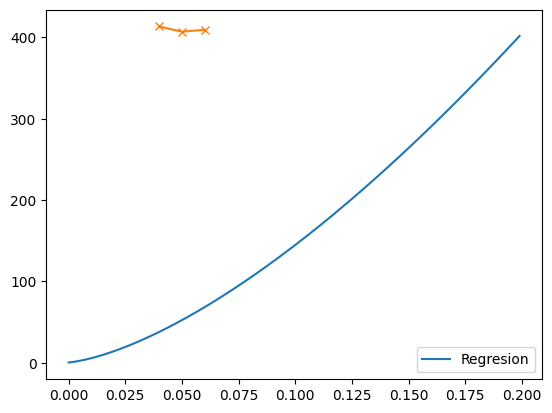

[413.4592790210367, 407.04532773674026, 409.39969532604704]


In [69]:
dictio = get_caudal_by_gap()
D = dictio["d"]
Q = dictio["q"]
D = np.array(D)/100 #pasando a centimetros
B = (200 /(0.7 * 0.2)) * np.sqrt(9.81)
Q_despejado = np.exp((np.log(Q/B))/(1.5))
popt, _ = curve_fit(linear_func, D, Q_despejado)
b_opt = popt[0] # c que aproxima. 
print(popt)

points = []
for d,q in zip(D,Q):
    points.append((d,q))
print(points[:][0])

plot_beverloo(points,b_opt)
print(Q)

In [20]:
dictio = get_caudal_by_gap()
B = (200 /(0.7 * 0.2)) * np.sqrt(9.81)
R = 0.01
for items in dictio.items():
    print(items)
bev = estimate_beverloo_constant(dictio)

predicted_Q = B * (dictio["d"] - bev * R) ** 1.5
predicted_Q

[413.4592790210367, 407.04532773674026, 409.39969532604704]
('d', [4, 5, 6])
('q', [413.4592790210367, 407.04532773674026, 409.39969532604704])


array([36068.14602258, 50330.4367313 , 66094.21340931])

In [11]:
time_delta = 1
time_bins = np.arange(0, 10, time_delta)

data = []
df_without_index = df.reset_index()
for i in range(0, len(time_bins) - 1):
    lower = time_bins[i]
    upper = time_bins[i + 1]

    particles = df_without_index[(df_without_index['time'] < upper) & (df_without_index['time'] >= lower)]['ball_id'].sum()
    data.append({'time': lower, 'particles': particles})

q_df = pd.DataFrame(data)
q_df.plot(x='time', y='particles')

q_df.mean()

NameError: name 'df' is not defined

In [ ]:
rolling_df = df.copy().reset_index()
rolling_df['Timestamp'] = pd.to_datetime(rolling_df['time'], unit='s')
rolling_df.set_index('Timestamp', inplace=True)
rolling_df.rolling(window='1000ms')['ball_id'].sum().plot()